In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# TODOs (from 09.06.2020)

1. Strip away the non-useful functions
2. Document the remaining functions
3. Move the remaining functions to modules
4. Test the modules
5. Clean up this NB

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [5]:
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [59]:
segs_plot_kwargs = {'linestyle':'--', 'marker':'o', 'color':'k', 'linewidth':4.0, 'markerfacecolor':'w', 'markersize':6.0, 'markeredgewidth':2.0}

In [60]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [61]:
eps = 0.25

## Testing the box method

Once the box (width is provided by the spatial tolerance) is positioned in a good way (_ie_ the centroid), extending the box forwards or backwards in time makes no change to the _score_ of the box.

Here, the score could be something like the number of points, the std/MSE; whatever it is, it should be saturated at some point and extending the box makes no difference, meaning that something converges which provides a stopping criterion. 

In [13]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays, get_stay_indices
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [50]:
from synthetic_data.trajectory_class import get_rand_traj, get_rand_stays

In [65]:
configs = {
    'threshold':0.5,
    'noise_min':0.02,
    'noise_max':0.15
}

time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
new_stays = get_adjusted_stays(segments, time_arr)
new_t_segs, new_x_segs = get_stay_segs(new_stays)

In [52]:
from numpy.linalg import lstsq

In [53]:
import pickle
from datetime import datetime

In [54]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

In [55]:
stays_tag = int((new_x_segs.size)/3)
date_tag = datetime.today().strftime('%Y%m%d')
notes = 'unconverging_example'
trajectory_tag = f"{date_tag}_trajectory_{stays_tag}stays__{notes}"

In [56]:
trajectory = {}
trajectory['segments'] = segments
trajectory['time_arr'] = time_arr
trajectory['raw_locs_arr'] = raw_arr
trajectory['nse_locs_arr'] = noise_arr

In [57]:
#pickle.dump( trajectory, open( trajectory_tag, "wb" ) )
#trajectory = pickle.load( open( "20200625_trajectory_8stays__adjusted.pkl", "rb" ) )

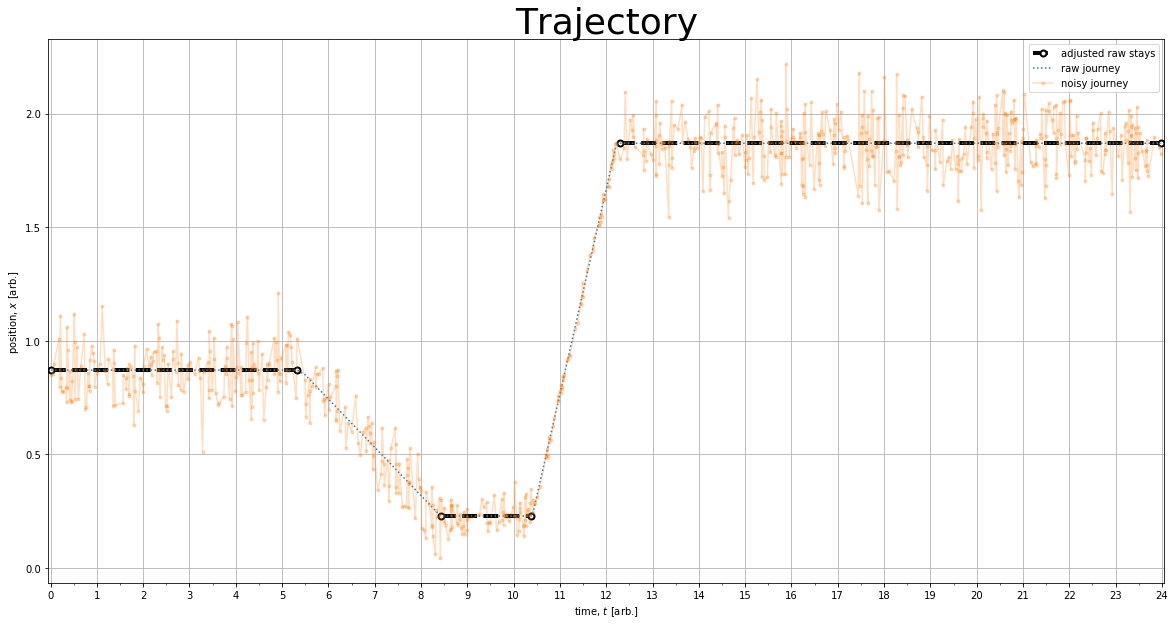

In [66]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
plt.plot(time_arr, raw_arr, ':', label='raw journey')
plt.plot(time_arr, noise_arr, '.-', label='noisy journey', alpha=0.25)

plt.legend();

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_arr.min()-1*eps
ymax = noise_arr.max()+1*eps
#plt.ylim(ymin, ymax)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Trajectory', fontsize=36)
plt.grid(visible=True); 

In [84]:
from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    
    # hyperparam
    nIterationMax = 20

    # Sorting the breaks
    breakpoints = np.sort( np.array(breakpoints) )

    # XDiffs
    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    # loop through the whole data set
    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        print(newBreakpoints.size,breakpoints.size)
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
        # MJS: included
        breakpoints = breakpoints[(breakpoints > X.min()) & (breakpoints < X.max())]
        breakpoints = np.sort( np.array(breakpoints) )        
        
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution    

5 5
5 5
5 5
5 5
5 5
5 5
5 5
5 5


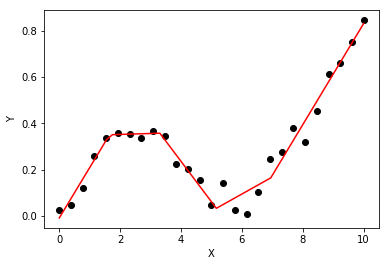

In [91]:
X = np.linspace( 0, 10, 27 )
Y = 0.2*X  - 0.3* ramp(X-2) + 0.3*ramp(X-6) + 0.05*np.random.randn(len(X))
plt.plot( X, Y, 'ok' );

initialBreakpoints = [1,3,5,7,9]
plt.plot( *SegmentedLinearReg( X, Y, initialBreakpoints ), '-r' );
plt.xlabel('X'); plt.ylabel('Y');

5 5
stop criterion reached [0.02859997 1.02674198 1.080355   0.30109154 0.19697976] vs 
5 5
stop criterion reached [ 4.45371753  0.01161487  0.20083218  0.62510121 10.25784858] vs 
3 3
stop criterion reached [0.03620307 0.02813872 0.45590802] vs 
3 3
stop criterion reached [3.85255540e-16 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [9.07214658e-16 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [6.58662697e-16 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [4.72248726e-16 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [1.05634583e-15 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [1.08120103e-15 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [6.58662697e-16 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [4.72248726e-16 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [1.05634583e-15 1.92328146e-02 5.22796094e-01] vs 
3 3
stop criterion reached [1.08120103e-15 1.923281

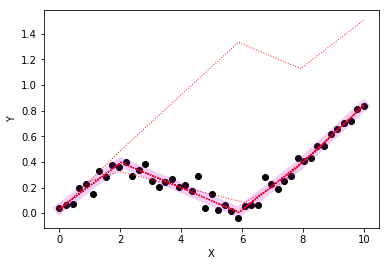

In [109]:
X = np.linspace( 0, 10, 47 )
Y = 0.2*X  - 0.3* ramp(X-2) + 0.3*ramp(X-6) + 0.05*np.random.randn(len(X))
plt.plot( X, Y, 'ok' );

initialBreakpoints = [1,3,5,7,9]


# hyperparam
nIterationMax = 20

# Sorting the breaks
breakpoints = np.sort( np.array(initialBreakpoints) )

# XDiffs
dt = np.min( np.diff(X) )
ones = np.ones_like(X)

# loop through the whole data set
for i in range( nIterationMax ):
    # Linear regression:  solve A*p = Y
    Rk = [ramp( X - xk ) for xk in breakpoints ]
    Sk = [step( X - xk ) for xk in breakpoints ]

    A = np.array([ ones, X ] + Rk + Sk )
    p =  lstsq(A.transpose(), Y, rcond=None)[0] 

    # Parameters identification:
    a, b = p[0:2]
    ck = p[ 2:2+len(breakpoints) ]
    dk = p[ 2+len(breakpoints): ]

    # Estimation of the next break-points:
    newBreakpoints = breakpoints - dk/ck 

    # Stop condition
    print(newBreakpoints.size,breakpoints.size)
    print( 'stop criterion reached',f"{abs(dk/ck)} vs ")#"{np.max(np.abs(newBreakpoints - breakpoints)):.5f}" )    
    if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
        
        print( 'stop criterion reached' )
        break

    breakpoints = newBreakpoints
    # MJS: included
    breakpoints = breakpoints[(breakpoints > X.min()) & (breakpoints < X.max())]
    breakpoints = np.sort( np.array(breakpoints) )     
    
    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones_ =  np.ones_like(Xsolution) 
    Rk_ = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones_ + b*Xsolution + np.sum( Rk_, axis=0 )
    plt.plot(Xsolution, Ysolution, 'r:', lw=1, alpha=0.9  );    

else:
    print( 'maximum iteration reached' )

# Compute the final segmented fit:
Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
ones_ =  np.ones_like(Xsolution) 
Rk_ = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

Ysolution = a*ones_ + b*Xsolution + np.sum( Rk_, axis=0 )
plt.plot(Xsolution, Ysolution, 'm-', lw=10, alpha=0.2 );

plt.xlabel('X'); plt.ylabel('Y');    

in loop 1 2.22759
in loop 2 2.44530
in loop 3 0.22183
in loop 4 2.22760
in loop 5 2.44531
in loop 5 0.22183
in loop 5 2.22760
in loop 5 0.22183
in loop 6 2.44532
in loop 6 0.22183
in loop 7 2.22761
in loop 7 2.44532
in loop 7 0.22183
in loop 7 2.22761
in loop 7 0.22183
in loop 7 2.22761
in loop 8 2.44533
in loop 8 2.44533
in loop 9 0.22184
in loop 10 2.22762
in loop 10 0.22184
in loop 10 2.22762
in loop 11 2.44534
in loop 11 0.22184
in loop 11 2.22762
in loop 11 2.44534
in loop 11 0.22184
in loop 11 2.22762
in loop 11 2.44534
in loop 11 0.22184
in loop 11 2.22762
in loop 11 0.22184
in loop 12 2.44535
in loop 12 0.22184
in loop 13 2.22763
in loop 13 2.44535
in loop 13 0.22184
in loop 13 2.22763
in loop 13 2.44535
in loop 13 0.22184
in loop 13 2.22763
in loop 13 2.44535
in loop 13 0.22184
in loop 13 2.22763
in loop 13 0.22184
in loop 13 2.22763
in loop 14 2.44536
in loop 14 0.22184
in loop 14 2.22763
in loop 14 2.44536
in loop 14 0.22184
in loop 14 2.22763
in loop 14 2.44536
in loop 14 2

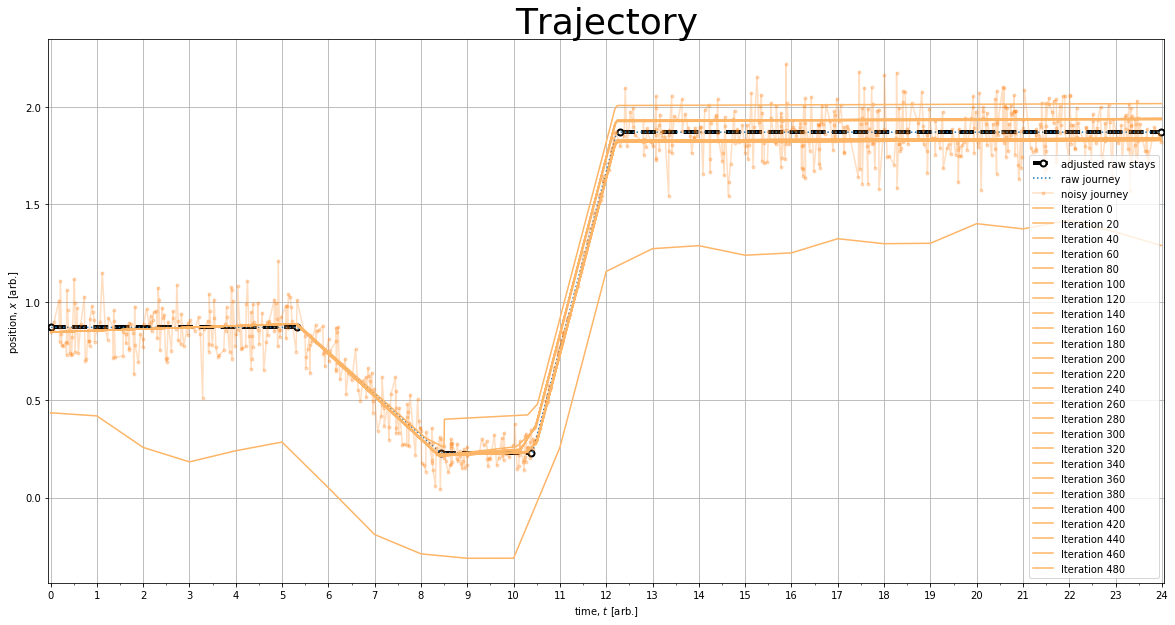

In [105]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
plt.plot(time_arr, raw_arr, ':', label='raw journey')
plt.plot(time_arr, noise_arr, '.-', label='noisy journey', alpha=0.25)

# hyperparam
nIterationMax = 500

# Sorting the breaks
#breakpoints = np.sort( np.array(breakpoints0) )
breakpoints = np.arange(0,24,1)

# time_arrDiffs
dt = np.min( np.diff(np.unique( time_arr)) )

ones = np.ones_like(time_arr)

yyysolution_last = noise_arr

all_breakpoints = []

loops1 = []
cycle = []
last_len = 0
set_len = 0
# loop through the whole data set
for i in range( nIterationMax ):
    
    #print(yyysolution_last.shape)
    
    ones = np.ones_like(time_arr)
    
    # Linear regression:  solve A*p = Y
    Rk = [ramp( time_arr - xk ) for xk in breakpoints ]
    Sk = [step( time_arr - xk ) for xk in breakpoints ]
    A = np.array([ ones, time_arr ] + Rk + Sk )
    p =  lstsq(A.transpose(), noise_arr, rcond=None)[0] 

    # Parameters identification:
    a, b = p[0:2]
    ck = p[ 2:2+len(breakpoints) ]
    dk = p[ 2+len(breakpoints): ]

    # Estimation of the next break-points:
    newBreakpoints = breakpoints - dk/ck 

    #print(np.max(np.abs(newBreakpoints - breakpoints)),dt/5, dt)
    # Stop condition
    if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
        print('Stopping criterion')
        #break
    
        
    # Compute the final segmented fit:
    xxxsolution = np.insert( np.append( breakpoints, max(time_arr) ), 0, min(time_arr) )
    ones =  np.ones_like(xxxsolution) 
    Rk = [ c*ramp( xxxsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    yyysolution = a*ones + b*xxxsolution + np.sum( Rk, axis=0 )

    # Compute the final segmented fit:
    ones_model =  np.ones_like(time_arr) 
    Rk_model = [ c*ramp( time_arr - x0 ) for x0, c in zip(breakpoints, ck) ]

    yyysolution_model = a*ones_model + b*time_arr + np.sum( Rk_model, axis=0 )
    
    norm_err = np.linalg.norm(yyysolution_model-yyysolution_last)
    round_norm_err = round(norm_err,5)
    if round_norm_err in loops1:

        cycle.append(round_norm_err)
        set_len = len(list(set(cycle)))
        consec = True
        print("in loop", set_len, f"{np.linalg.norm(yyysolution_model-yyysolution_last):.5f}")        
    else:    
        loops1.append(round_norm_err)
        consec = False
    
    
    #print(norm_err, yyysolution.size, breakpoints.size )
    if np.linalg.norm(yyysolution_model-yyysolution_last) < 0.01:
        print(f'{i}: Stopping criterion #2')
        
    #print(yyysolution.shape)
    if i%20==0:
        plt.plot(xxxsolution, yyysolution, color=colors[i%len(colors)-1], label=f'Iteration {i}')
    
    breakpoints = newBreakpoints
    breakpoints = breakpoints[(breakpoints > time_arr.min()) & (breakpoints < time_arr.max())]
    breakpoints = np.sort( breakpoints )
    all_breakpoints.append(breakpoints)
    yyysolution_last = yyysolution_model
    
    #if i%50:
    #    print(["{0:0.2f}".format(i) for i in breakpoints],len(breakpoints),len(xxxsolution))
    
    if len(cycle) > 0:
        if (last_len == set_len) & consec & (round_norm_err == min(cycle)):
            break
    else:
        last_len = set_len
    

plt.legend();

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_arr.min()-1*eps
ymax = noise_arr.max()+1*eps
#plt.ylim(ymin, ymax)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Trajectory', fontsize=36)
plt.grid(visible=True);    

In [61]:
(len(all_breakpoints),all_breakpoints[-1].size)

(500, 21)

In [62]:
all_breakpoints[0]

array([ 1.50413077,  1.9246606 ,  2.94195132,  3.80164737,  4.98960558,
        5.8018437 ,  6.18327122,  8.74633063,  8.81272119,  9.77535501,
       11.25046315, 11.38551192, 11.75225171, 14.09881262, 14.18374918,
       15.90271017, 16.34243036, 18.2679987 , 19.2390766 , 19.70580585,
       21.03068025, 22.24770133, 23.33342169])

In [63]:
plot_all_breakpoints[0,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [64]:
plot_all_breakpoints = np.empty(shape=(len(all_breakpoints),all_breakpoints[-1].size))
plot_all_breakpoints[:,:] = np.NaN

In [65]:
for n,row in enumerate(all_breakpoints):
    #print(row)
    if row.size == all_breakpoints[-1].size:
        plot_all_breakpoints[n,:] = row

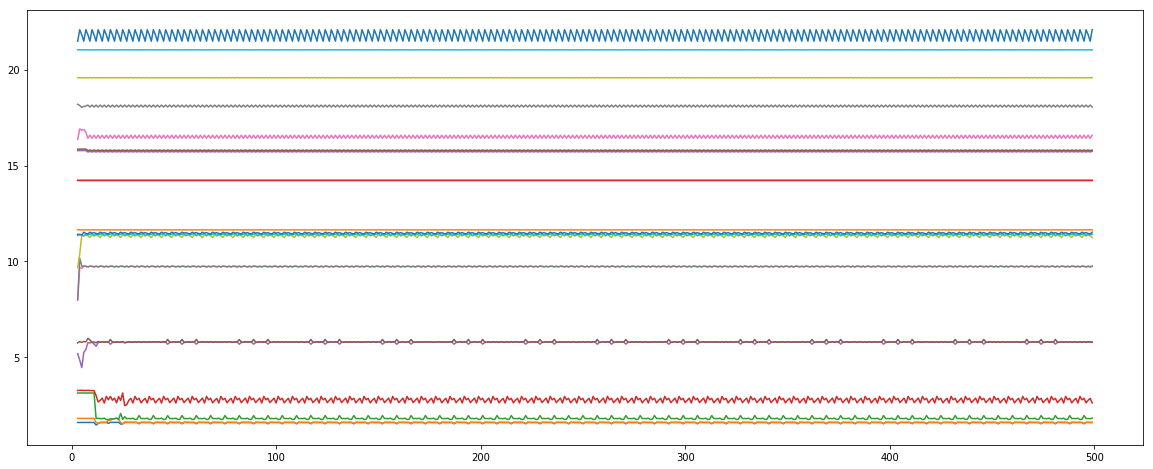

In [66]:
plt.figure(figsize=[20,8])
plt.plot(plot_all_breakpoints);

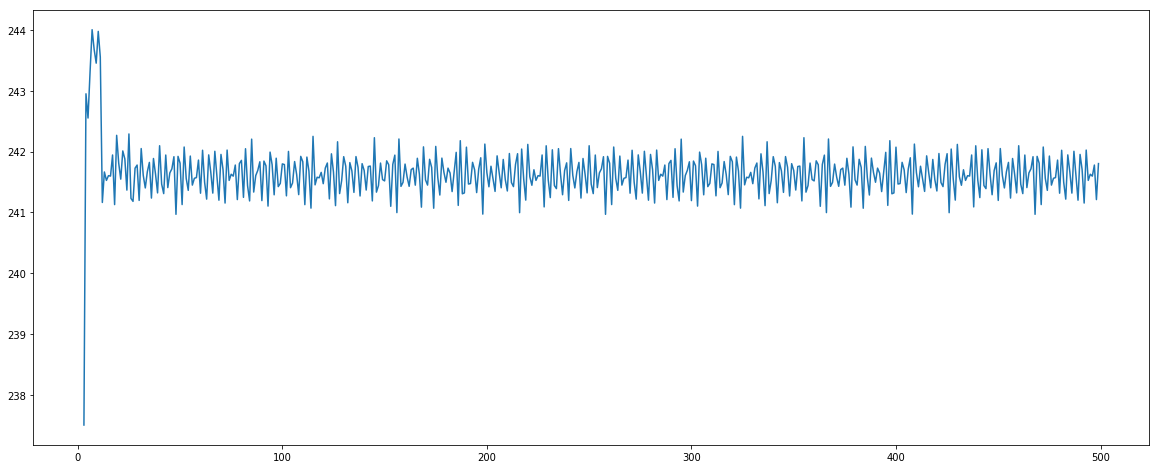

In [67]:
plt.figure(figsize=[20,8])
plt.plot(np.sum(plot_all_breakpoints, axis=1));

**Note** sometimes the errors don't converge; make the breakpoints do?

### Eval

In [ ]:
calc_slope = lambda x1,y1,x2,y2: (y2-y1)/(x2-x1)

In [ ]:
final_pairs = []
for n in range(0,len(yyysolution)-1,1):
    
    slope = calc_slope(xxxsolution[n],yyysolution[n],xxxsolution[n+1],yyysolution[n+1])
    
    print(slope)
    
    mask = np.where((time_arr >= xxxsolution[n]) & (time_arr < xxxsolution[n+1]))
    
    if abs(slope) < 0.1:
        final_pairs.append((mask[0][0],mask[0][-1]))

In [ ]:
from synthetic_data.trajectory import get_stay_indices

In [ ]:
true_indices = get_stay_indices(new_stays, time_arr)

In [ ]:
true_labels = np.zeros(time_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

np.sum(true_labels), true_labels.size-np.sum(true_labels), true_labels.size, np.sum(true_labels)/true_labels.size

In [ ]:
pred_labels = np.zeros(time_arr.shape)
for pair in final_pairs:
    pred_labels[pair[0]:pair[1]+1] = 1

In [ ]:
np.sum(pred_labels), pred_labels.size-np.sum(pred_labels), pred_labels.size, np.sum(pred_labels)/pred_labels.size

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

confusion_matrix(true_labels, pred_labels)

In [ ]:
precision_score(true_labels, pred_labels), recall_score(true_labels, pred_labels), 

In [ ]:
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax1.plot(time_arr, raw_arr, ':', label='raw journey')
ax1.plot(time_arr, noise_arr, '.-', label='noisy journey', alpha=0.5)
        
ax1.plot(xxxsolution, yyysolution, '--', label=f'Iteration {i}')
        

ax1.legend();

ax1.set_xlabel(r'time, $t$ [arb.]')
ax1.set_ylabel(r'position, $x$ [arb.]')

ymin = noise_arr.min()-1*eps
ymax = noise_arr.max()+1*eps
#plt.ylim(ymin, ymax)

ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))

ax1.set_xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

ax1.set_title('Trajectory', fontsize=36)
ax1.grid(visible=True);    

ax2 = fig.add_subplot(2,1,2, adjustable='box', aspect=1.5, sharex=ax1)

ax2.plot(time_arr, true_labels, 'X:', markersize=8, label='True')
ax2.plot(time_arr, pred_labels, '.', label='Pred.')
ax2.set_ylim(-0.2,1.2)
ax2.set_xlim(-0.5,24.5)

'''ax = plt.gca()

ax2.xaxis.set_major_locator(MultipleLocator(1))

#ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
'''
plt.xlabel(r'time, $t$ [arb.]')

ax2.set_yticks([0,1])
ax2.set_yticklabels(['travel', 'stay'])
ax2.legend()
#ax2.set_title('Trajectory', fontsize=36)
ax2.grid(visible=True);    

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [ ]:
datetag = datetime.today().strftime('%Y%m%d')

In [ ]:
### pickle.dump( trajectory, open( trajectory_tag, "wb" ) )
#trajectory = pickle.load( open( "20200625_trajectory_8stays__adjusted.pkl", "rb" ) )

In [ ]:
prec_scores, reca_scores = [], []

nnnn = 0

while nnnn < 1:
    
    if nnnn%10 == 0: print(nnnn)
    try:
        
        # Create data
        time_arr, raw_arr, noise_arr, segments = get_rand_traj()
        new_stays = get_adjusted_stays(segments, time_arr)
        new_t_segs, new_x_segs = get_stay_segs(new_stays) 
        
        min_t, max_t = time_sub.min(), time_sub.max()

        '''fig, ax = plt.subplots(1,1,figsize=(22,10))

        # The adjusted raw-stays
        plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
        plt.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
        plt.plot(time_sub, raw_journey_sub, ':', color='C0', label='raw journey')
        '''
        
        # hyperparam
        nIterationMax = 100

        # Sorting the breaks
        #breakpoints = np.sort( np.array(breakpoints0) )
        breakpoints = np.arange(0,24,1)

        # time_arrDiffs
        dt = np.min( np.diff(np.unique( time_arr)) )

        ones = np.ones_like(time_arr)

        yyysolution_last = noise_arr


        loops1 = []
        cycle = []
        last_len = 0
        set_len = 0
        # loop through the whole data set
        for i in range( nIterationMax ):

            #print(yyysolution_last.shape)

            ones = np.ones_like(time_arr)

            # Linear regression:  solve A*p = Y
            Rk = [ramp( time_arr - xk ) for xk in breakpoints ]
            Sk = [step( time_arr - xk ) for xk in breakpoints ]
            A = np.array([ ones, time_arr ] + Rk + Sk )
            p =  lstsq(A.transpose(), noise_arr, rcond=None)[0] 

            # Parameters identification:
            a, b = p[0:2]
            ck = p[ 2:2+len(breakpoints) ]
            dk = p[ 2+len(breakpoints): ]

            # Estimation of the next break-points:
            newBreakpoints = breakpoints - dk/ck 

            #print(np.max(np.abs(newBreakpoints - breakpoints)),dt/5, dt)
            # Stop condition
            #if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            #    print('Stopping criterion')
            #    #break


            # Compute the final segmented fit:
            xxxsolution = np.insert( np.append( breakpoints, max(time_arr) ), 0, min(time_arr) )
            ones =  np.ones_like(xxxsolution) 
            Rk = [ c*ramp( xxxsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

            yyysolution = a*ones + b*xxxsolution + np.sum( Rk, axis=0 )

            # Compute the final segmented fit:
            ones_model =  np.ones_like(time_arr) 
            Rk_model = [ c*ramp( time_arr - x0 ) for x0, c in zip(breakpoints, ck) ]

            yyysolution_model = a*ones_model + b*time_arr + np.sum( Rk_model, axis=0 )

            norm_err = np.linalg.norm(yyysolution_model-yyysolution_last)
            round_norm_err = round(norm_err,5)
            if round_norm_err in loops1:

                cycle.append(round_norm_err)
                set_len = len(list(set(cycle)))
                consec = True
                #print("in loop", set_len)        
            else:    
                loops1.append(round_norm_err)
                consec = False

            #print(norm_err, yyysolution.size, breakpoints.size )
            #if np.linalg.norm(yyysolution_model-yyysolution_last) < 0.01:
            #    print(f'{i}: Stopping criterion #2')

            breakpoints = newBreakpoints
            breakpoints = breakpoints[(breakpoints > time_arr.min()) & (breakpoints < time_arr.max())]
            breakpoints = np.sort( breakpoints )

            yyysolution_last = yyysolution_model

            if len(cycle) > 0:
                if (last_len == set_len) & consec & (round_norm_err == min(cycle)):
                    print(f'{i}: Stopping criterion #3')
                    break
            else:
                last_len = set_len

                
        #=======================================================                
        '''plt.plot(xxxsolution, yyysolution, color="C5" , label='Piece. lin.')

        plt.legend();

        plt.xlabel(r'time, $t$ [arb.]')
        plt.ylabel(r'position, $x$ [arb.]')

        ymin = noise_journey_sub.min()-1*eps
        ymax = noise_journey_sub.max()+1*eps
        #plt.ylim(ymin, ymax)

        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))

        plt.xlim(-0.05, 24.05)
        #plt.xlim(-0.1, 19.1
        #plt.xlim(15.1, 19.1)
        plt.grid(visible=True)'''
        #=======================================================
        
        #print(len(yyysolution))
        # Calc slope to identify 
        calc_slope = lambda x1,y1,x2,y2: (y2-y1)/(x2-x1)
        final_pairs = []
        for n in range(0,len(yyysolution)-1,1):

            slope = calc_slope(xxxsolution[n],yyysolution[n],xxxsolution[n+1],yyysolution[n+1])

            #print(slope)

            mask = np.where((time_arr >= xxxsolution[n]) & (time_arr < xxxsolution[n+1]))

            if abs(slope) < 0.1:
                final_pairs.append((mask[0][0],mask[0][-1]))

        true_indices = get_stay_indices(new_stays, time_arr)
        true_labels = np.zeros(time_arr.shape)

        for pair in true_indices:
            true_labels[pair[0]:pair[1]+1] = 1

        pred_labels = np.zeros(time_arr.shape)
        for pair in final_pairs:
            pred_labels[pair[0]:pair[1]+1] = 1


        prec = precision_score(true_labels, pred_labels)
        rec  = recall_score(true_labels, pred_labels)
        
        '''plt.title(f'Trajectory, prec.: {prec}, rec. {rec}', fontsize=36)
        plt.savefig(trajectory_tag+'.png')'''
        #=======================================================            
            
        #print(precision_score(true_labels, pred_labels))
        #confusion_matrix(true_labels, pred_labels)
        prec_scores.append(prec)
        reca_scores.append(rec)
        
        nnnn+=1
    except:
        pass
    


In [81]:
preciss = np.array(prec_scores)
recalls = np.array(reca_scores)

#print(preciss.mean(), recalls.mean())
recaprec = np.hstack([recalls.reshape(-1,1),preciss.reshape(-1,1)])
recaprec = recaprec[recaprec[:,0].argsort()]

In [82]:
preciss.mean(), (1-recalls).mean()

(0.8732896228971392, 0.14475514481781354)

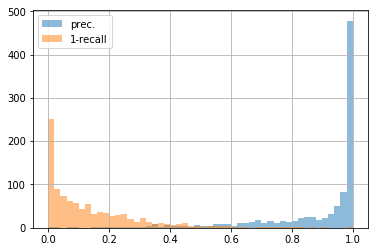

In [83]:
binw = 0.02
bins=np.arange(0,1.0+binw,binw)
_ = plt.hist(preciss, bins=bins, alpha=0.5, label='prec.')
_ = plt.hist(1-recalls, bins=bins, alpha=0.5, label='1-recall')
plt.legend()
plt.grid();

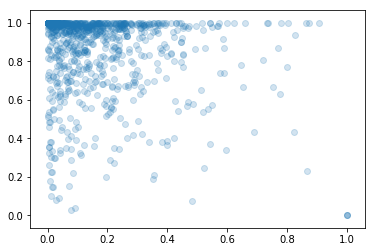

In [85]:
plt.scatter(1.-recaprec[:,0], recaprec[:,1], alpha=0.2)